In [1]:
#Necessary Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter


stop=set(stopwords.words('english'))
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#read and load data

In [4]:
df = pd.read_csv('/content/sample_data/Student Sentiment Data.csv')

In [5]:
df

,ID,Polarity,Comment
0,1,Neutral,"No issue in it, just little bit of old fashioned"
1,2,Neutral,Exam pattern and how it is conducted is really...
2,3,Negative,Not upto the mark.
3,4,Negative,not good improve it
4,5,Negative,very difficults exams
...,...,...,...
215,216,Positive,exam pattern is good and marks distribution is...
216,217,Neutral,all are good
217,218,Positive,The examination pattern is good .But time is n...
218,219,Neutral,MCQ pattern is quite good and efficient way fo...


In [6]:
df = df[['Polarity','Comment']]

In [7]:
df.Polarity.unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [8]:
aspect_mapping = {'Positive': 1 ,'Negative': 2 , 'Neutral': 0}

df['Polarity_label'] = df['Polarity'].map(aspect_mapping)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Polarity        220 non-null    object
 1   Comment         220 non-null    object
 2   Polarity_label  220 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.3+ KB


In [10]:
df.describe()

,Polarity_label
count,220.000000
mean,0.995455
std,0.644596
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [11]:
df.isnull().sum()

Polarity          0
Comment           0
Polarity_label    0
dtype: int64

In [12]:
#Exploratory Data Analysis

In [13]:
#Funnel Chart

In [14]:
from plotly import graph_objs as go
temp = df.groupby('Polarity').count()['Comment'].reset_index().sort_values(by='Comment',ascending=False)

fig = go.Figure(go.Funnelarea(
    text =temp.Polarity,
    values = temp.Comment,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [15]:
df['Polarity'].value_counts()

Positive    129
Neutral      46
Negative     45
Name: Polarity, dtype: int64

In [16]:
#Pie Chart

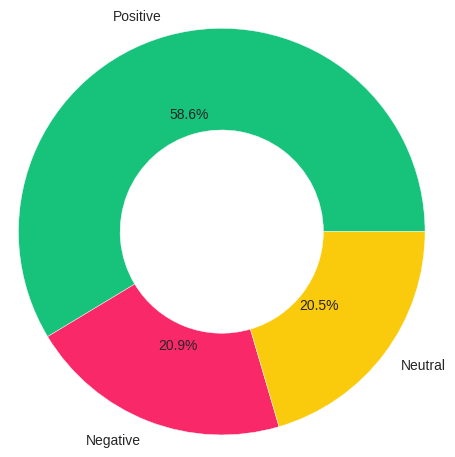

In [17]:
class_df = df.groupby('Polarity').count()['Comment'].reset_index().sort_values(by='Comment',ascending=False)
percent_class=class_df.Comment

labels= ['Positive','Negative','Neutral']

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white')

plt.show()

In [18]:
#There is an uneven distribution in the data with the largest portion belongs to Positive followed by Negative and Neutral.

In [19]:
#Number of Characters in Review

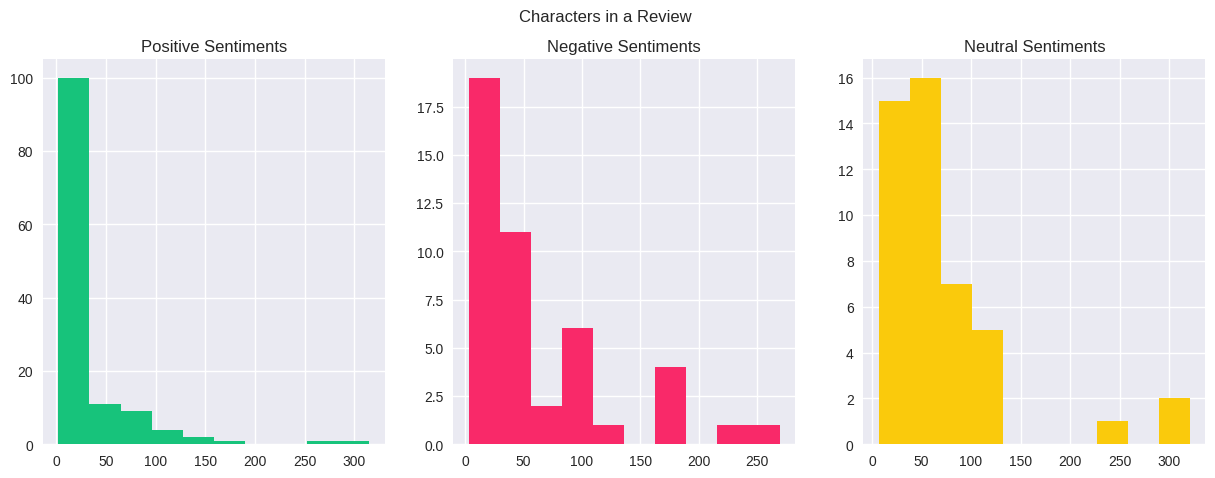

In [20]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=df[df['Polarity']=="Positive"]['Comment'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=df[df['Polarity']=="Negative"]['Comment'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=df[df['Polarity']=="Neutral"]['Comment'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in a Review')
plt.show()

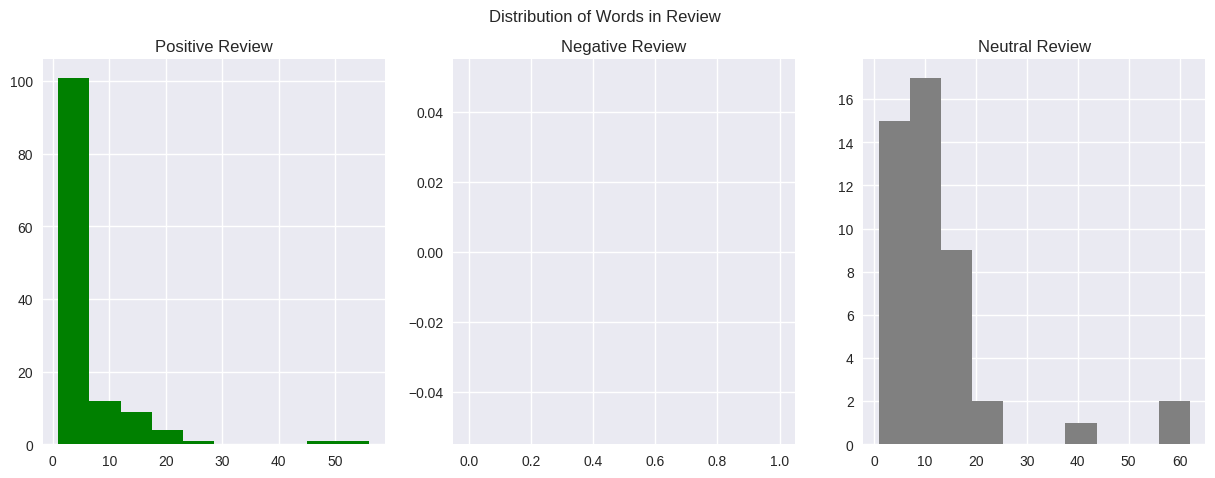

In [21]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
text_len=df[df['Polarity_label']==1]['Comment'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Review')
text_len=df[df['Polarity_label']==-1]['Comment'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Review')
text_len=df[df['Polarity_label']==0]['Comment'].str.split().map(lambda x: len(x))
ax3.hist(text_len,color='gray')
ax3.set_title('Neutral Review')
fig.suptitle('Distribution of Words in Review')
plt.show()

Text(0.5, 0.98, 'Average word length in each feedback')

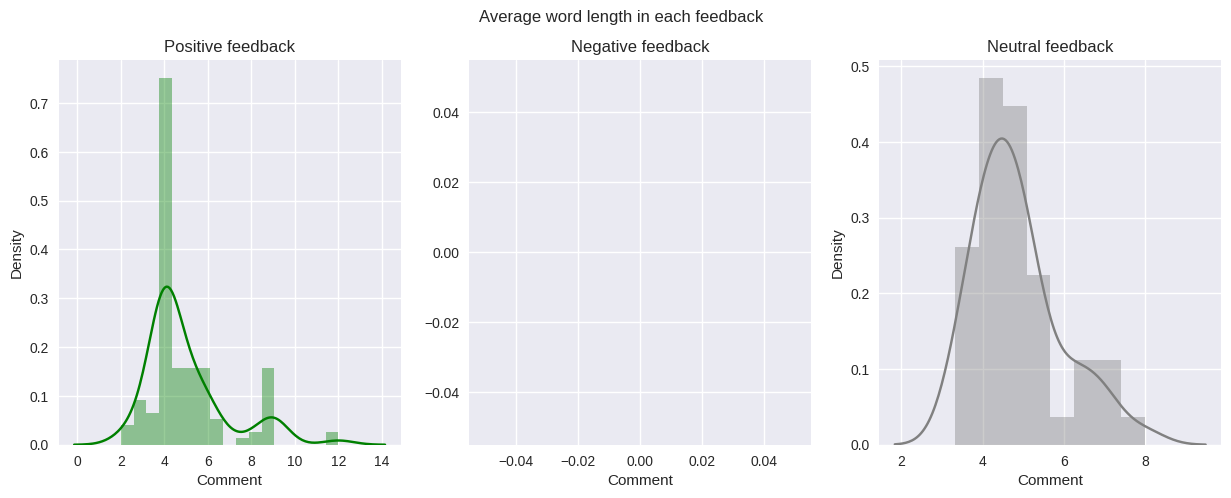

In [22]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
word=df[df['Polarity_label']==1]['Comment'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Positive feedback')
word=df[df['Polarity_label']==-1]['Comment'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative feedback')
word=df[df['Polarity_label']==0]['Comment'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='grey')
ax3.set_title('Neutral feedback')
fig.suptitle('Average word length in each feedback')

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [24]:
import sys
sys.version

'3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]'

<Axes: >

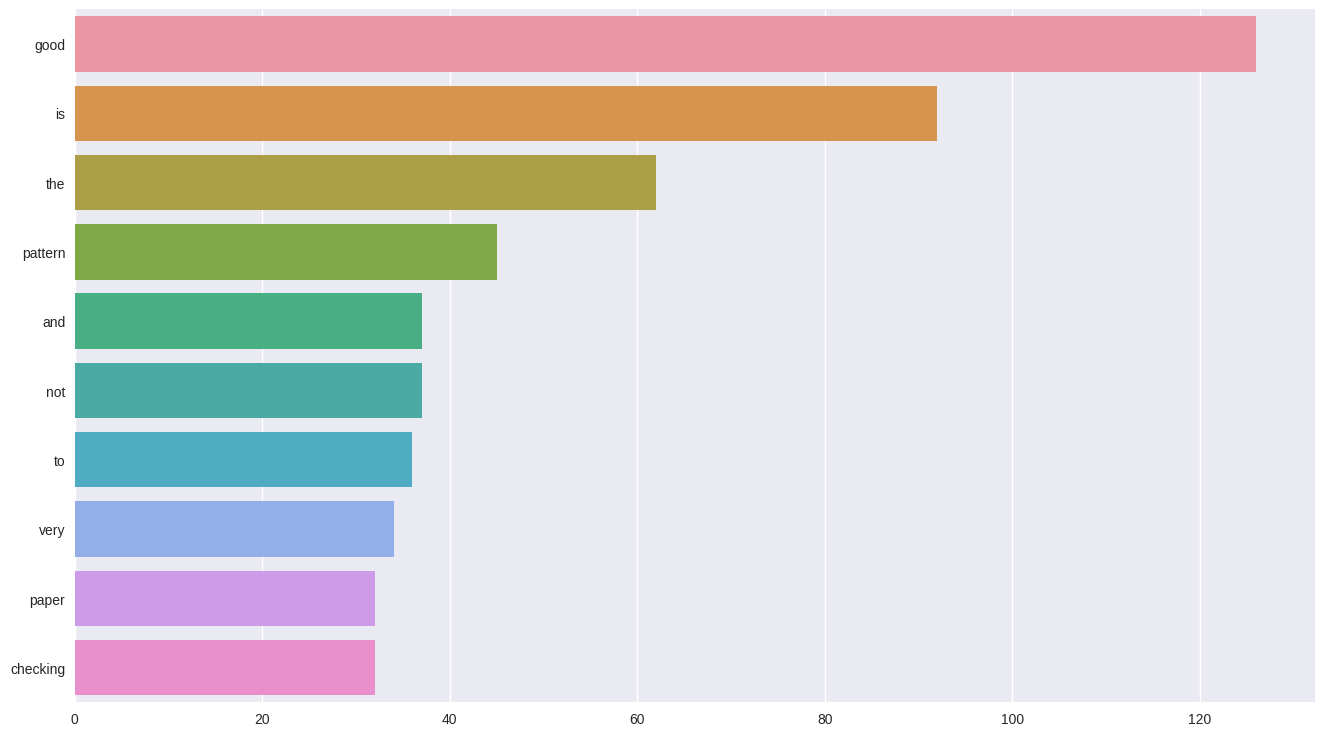

In [25]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Comment,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

In [26]:
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [27]:
#Common Stopwards in Text

In [28]:
import numpy as np

def create_corpus(target):
    corpus=[]

    for x in df[df['Polarity']==target ]['Comment'].str.split():
        for i in x:
            if i  in stop:
                corpus.append(i)
    return corpus

np.array(stop)

array({'from', 'your', 'as', 'whom', 'is', 'by', 'while', 'below', 'doesn', 'its', 'this', 'until', 'over', 'with', 'wasn', 'any', 'being', 'o', 'such', 'what', "haven't", "you'd", 'myself', 'all', 'same', 'were', 've', 'ain', "wouldn't", 'after', 'yours', 'you', 'under', 'me', 'didn', 'both', 'of', 'and', 'than', "you're", 'out', 'between', 'wouldn', 'in', 'itself', "didn't", 'y', 'nor', 'their', 'each', "isn't", "doesn't", 'herself', 'when', 'more', 'those', 'll', 'few', 'can', 'if', 'most', 'd', 'them', 'further', 'for', 'at', 'only', 'couldn', "hadn't", "that'll", 'very', 'themselves', 'did', 'hasn', "needn't", "couldn't", 'don', 'hers', 'about', 'was', "you've", 'then', 'hadn', "mustn't", 'above', "wasn't", 'or', "weren't", 'shan', 'should', 'does', 'some', 'needn', "shan't", 're', 'she', 'into', 'once', "aren't", "it's", 'a', 'it', 'isn', "won't", 'that', 'we', 'through', 'not', 'ours', 'been', 'yourselves', 'there', 'theirs', 'mustn', 'other', 'do', 'am', 'how', 'he', 'will', 'h

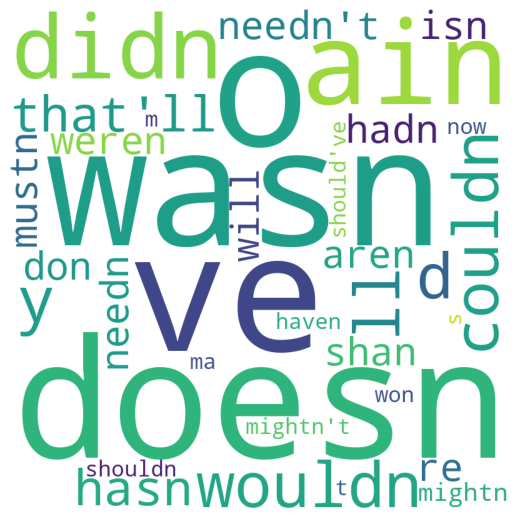

In [29]:
comment_words = ''
stopwords = set(STOPWORDS)


for val in stop:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 5), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

<BarContainer object of 10 artists>

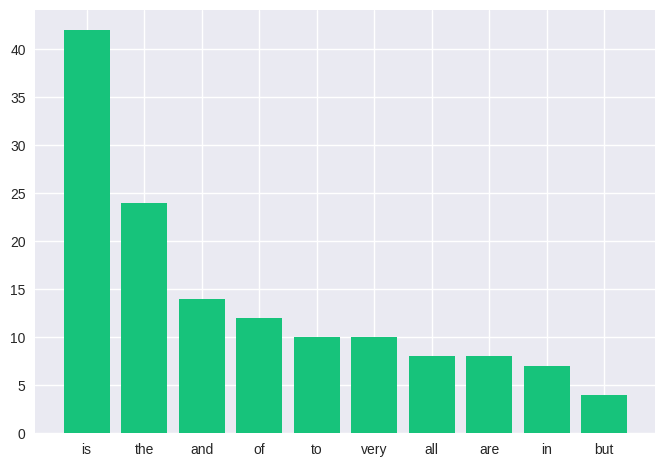

In [30]:
corpus=create_corpus("Positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

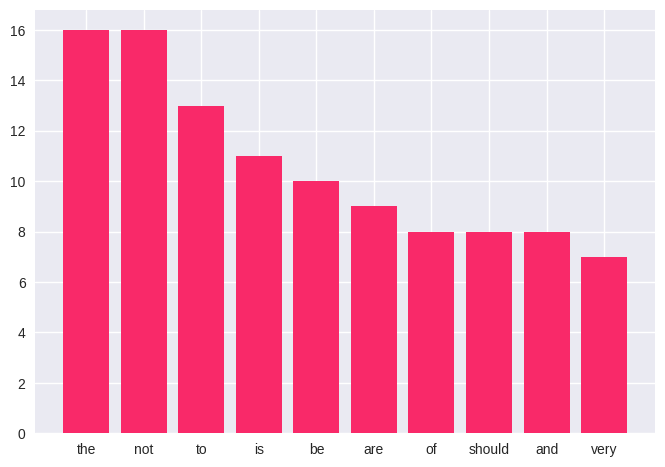

In [31]:
corpus=create_corpus("Negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

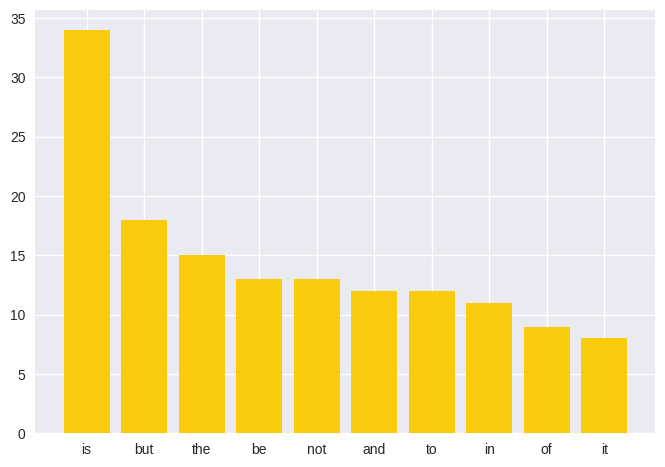

In [32]:
corpus=create_corpus("Neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

In [33]:
#World Cloud of Every Polarity

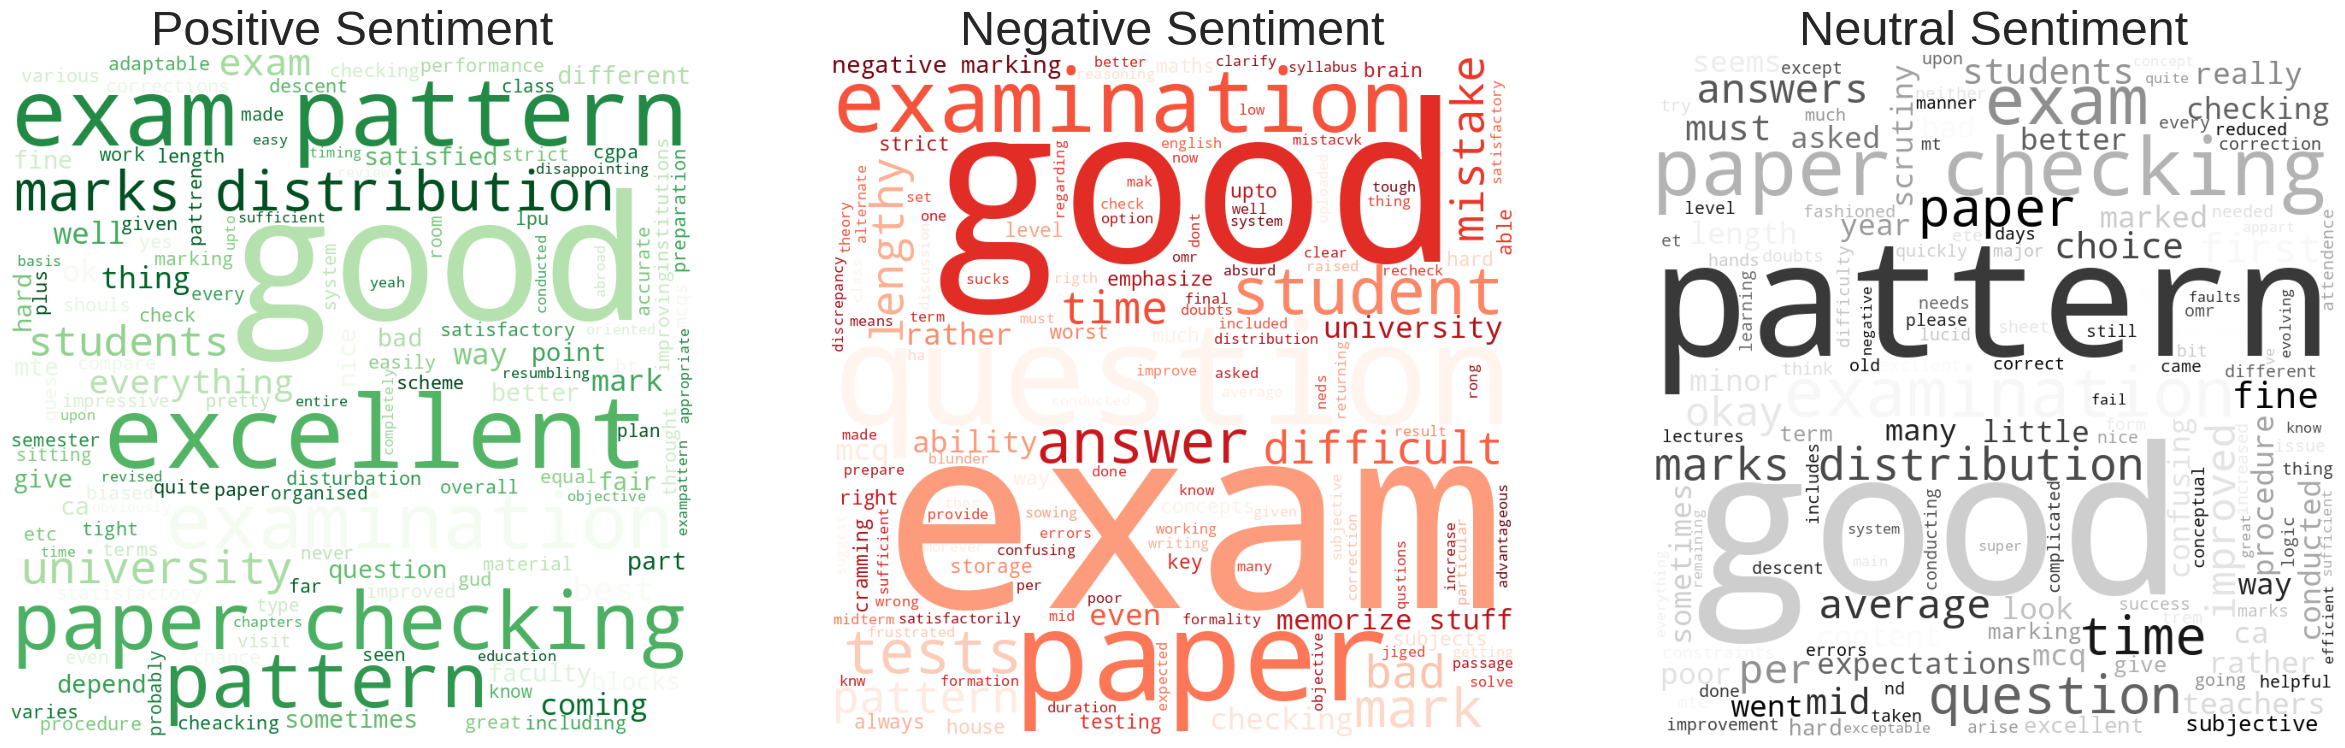

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["Polarity"]=="Positive"]
df_neg = df[df["Polarity"]=="Negative"]
df_neu = df[df["Polarity"]=="Neutral"]

comment_words = ''
stopwords = set(STOPWORDS)

for val in df_pos.Comment:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "


wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in df_neg.Comment:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "


wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in df_neu.Comment:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "


wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Sentiment',fontsize=35);

In [35]:
import tensorflow as tf

In [36]:
!pip install transformers

In [37]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
!pip install openpyxl

In [40]:
df.head(10)

,Polarity,Comment,Polarity_label
0,Neutral,"No issue in it, just little bit of old fashioned",0
1,Neutral,Exam pattern and how it is conducted is really...,0
2,Negative,Not upto the mark.,2
3,Negative,not good improve it,2
4,Negative,very difficults exams,2
5,Neutral,Fine but still can be improved,0
6,Negative,Worst examination pattern,2
7,Negative,Again the university tests students of their a...,2
8,Negative,The examination pattern is good but the class ...,2
9,Neutral,"Exams came too quickly, 20 days between minors...",0


In [41]:
df = df[['Polarity_label','Comment']]

In [42]:
index = df.index
number_of_rows = len(index)
print(number_of_rows)

220


In [43]:
df.head(10)

,Polarity_label,Comment
0,0,"No issue in it, just little bit of old fashioned"
1,0,Exam pattern and how it is conducted is really...
2,2,Not upto the mark.
3,2,not good improve it
4,2,very difficults exams
5,0,Fine but still can be improved
6,2,Worst examination pattern
7,2,Again the university tests students of their a...
8,2,The examination pattern is good but the class ...
9,0,"Exams came too quickly, 20 days between minors..."


In [44]:
#Preprocessing

In [45]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['comment_new']=df['Comment'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['comment_new']=df['comment_new'].apply(lambda x:remove_html(x))

In [46]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
df['comment_new']=df['comment_new'].apply(lambda x:lower(x))

In [47]:
# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['comment_new']=df['comment_new'].apply(lambda x:remove_num(x))

In [48]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['comment_new']=df['comment_new'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['comment_new']=df['comment_new'].apply(lambda x:remove_stopwords(x))

In [49]:
#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
df['comment_new']=df['comment_new'].apply(lambda x:remove_space(x))

In [50]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def lemmatize_words(text):
    wnl = WordNetLemmatizer()
    lem = ' '.join([wnl.lemmatize(word) for word in text.split()])
    return lem

df['comment_new'] = df['comment_new'].apply(lemmatize_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
reviews = df['comment_new'].values.tolist()
labels = df['Polarity_label'].tolist()

In [52]:
print(reviews[:2])
print(labels[:2])

['issue little bit old fashioned', 'exam pattern conducted really seems good first year went scrutiny first time per expectation teacher marked answer per choice must look content rather length answer poor paper checking']
[0, 0]


In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.2,random_state = 23)
validation_sentences, test_sentences, validation_labels, test_labels = train_test_split(validation_sentences, validation_labels, test_size=.5,random_state = 23)

In [54]:
len(training_sentences)

176

In [55]:
len(validation_sentences)

22

In [56]:
len(test_sentences)

22

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1, 2))

#training_sentences_Tf = tfidf.fit_transform(training_sentences)

#test_sentences_Tf = tfidf.transform(test_sentences)

In [58]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [59]:
tokenizer([training_sentences[0]], truncation=True, padding=True, max_length=512)

{'input_ids': [[101, 11360, 5418, 4146, 2428, 3849, 2204, 2034, 2095, 2253, 17423, 2034, 2051, 2566, 17626, 3836, 4417, 3437, 2566, 3601, 2442, 2298, 4180, 2738, 3091, 3437, 3532, 3259, 9361, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [60]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

In [62]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [63]:
model.save_pretrained("./sentiment")

In [64]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("./sentiment")

Some layers from the model checkpoint at ./sentiment were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./sentiment and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
test_sentence = "I absolutely loved the lecturer, George Siedel. He presents in a way where I wanted to listen and I feel like I learned a lot from him just with the way that he spoke. I definitely think that this course is worth doing and I am really happy that did it. The fact that the course was online, didn't feel like it was a barrier to me at all. In fact, I preferred it because I was able to go through the work in my own pace and was thus able to complete the entire course in one week. I really enjoyed this course, and definitely think that the lecturer, George Siedel, played a big part in it. I haven't done many other online courses before, but I'm definitely motivated to try more of Coursera's courses due to the great experience that I had taking this course. Due to the introduction of the University of Michigan made, I am now also strongly considering to apply for the MBA course when I am able."


predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = loaded_model.predict(predict_input)[0]


tf_prediction = tf.nn.softmax(tf_output, axis=1)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(label)

1/1 [==============================] - 14s 14s/step
[0]


In [66]:
test_labels[0]

1

In [67]:
predict_input = []
y_hat = []
predictions = []

for x in test_sentences:
   predict_input.append(tokenizer.encode(x,truncation=True,padding=True,return_tensors="tf"))

for x in predict_input:
  y_hat.append(loaded_model.predict(x)[0])


for j in y_hat:
  tf_prediction = tf.nn.softmax(j, axis=1)
  label = tf.argmax(tf_prediction, axis=1)
  label = label.numpy()
  predictions.append(label)

1/1 [==============================] - 0s 258ms/step


In [68]:
tokenizer.save_pretrained("./sentiment")

('./sentiment/tokenizer_config.json',
 './sentiment/special_tokens_map.json',
 './sentiment/vocab.txt',
 './sentiment/added_tokens.json',
 './sentiment/tokenizer.json')

In [69]:
label

array([1])

In [70]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [71]:
#NAIVE BAYES

In [72]:
# Model 1 - default parameter
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

nb_classifier1 = MultinomialNB()

# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf', tfidf),
                            ('model',nb_classifier1) ])

pipeline.fit(training_sentences,training_labels)


pred1 = pipeline.predict(test_sentences)

print(classification_report(test_labels,pred1, target_names = ['Positive','Negative','Neutral']))

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00         4
    Negative       0.70      1.00      0.82        14
     Neutral       1.00      0.25      0.40         4

    accuracy                           0.68        22
   macro avg       0.57      0.42      0.41        22
weighted avg       0.63      0.68      0.60        22



In [73]:
precision = precision_score(test_labels, pred1,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(test_labels, pred1,average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(test_labels, pred1,average='weighted')
print('F1 Score: %f' % f1)

Precision: 0.627273
Recall: 0.681818
F1 Score: 0.596791


In [74]:
# Model 2
from sklearn.svm import SVC

svc_model1 = SVC(C=1, kernel='linear', gamma= 1)

# define the stages of the pipeline
Model = Pipeline(steps= [('tfidf', tfidf),
                            ('model',svc_model1) ])

Model.fit(training_sentences,training_labels)

pred1 = Model.predict(test_sentences)

print(classification_report(test_labels, pred1, target_names = ['Positive','Negative','Neutral']))

              precision    recall  f1-score   support

    Positive       0.50      0.75      0.60         4
    Negative       0.92      0.79      0.85        14
     Neutral       0.50      0.50      0.50         4

    accuracy                           0.73        22
   macro avg       0.64      0.68      0.65        22
weighted avg       0.77      0.73      0.74        22



In [75]:
accuracy = accuracy_score(test_labels, pred1)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_labels, pred1,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(test_labels, pred1,average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(test_labels, pred1,average='weighted')
print('F1 Score: %f' % f1)

Accuracy: 0.727273
Precision: 0.765152
Recall: 0.727273
F1 Score: 0.738462


In [76]:
acccuracy = accuracy_score(test_labels, pred1)
precision = precision_score(test_labels, pred1,average='weighted')
recall = recall_score(test_labels, pred1,average='weighted')
f1_score = f1_score(test_labels, pred1,average='weighted')

print("********* Support Vector Classifier *********")
print("\tAccuracy    : ", acccuracy)
print("\tPrecision   : ", precision)
print("\tRecall      : ", recall)
print("\tF1 Score    : ", f1_score)

********* Support Vector Classifier *********
	Accuracy    :  0.7272727272727273
	Precision   :  0.7651515151515151
	Recall      :  0.7272727272727273
	F1 Score    :  0.7384615384615384


In [77]:
# Model 3
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf', tfidf),
                            ('model',rf) ])

pipeline.fit(training_sentences,training_labels)

prediction1 = pipeline.predict(test_sentences)

print(classification_report(test_labels, prediction1, target_names = ['Positive','Negative','Neutral']))

              precision    recall  f1-score   support

    Positive       0.25      0.25      0.25         4
    Negative       0.61      0.79      0.69        14
     Neutral       0.00      0.00      0.00         4

    accuracy                           0.55        22
   macro avg       0.29      0.35      0.31        22
weighted avg       0.43      0.55      0.48        22



In [78]:
precision = precision_score(test_labels, prediction1,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(test_labels, prediction1,average='weighted')
print('Recall: %f' % recall)

Precision: 0.434343
Recall: 0.545455


In [79]:
!pip install catboost
from catboost import CatBoostClassifier

clfs = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    #loss_function='CrossEntropy'
)

# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf', tfidf),
                            ('model',clfs) ])

pipeline.fit(training_sentences,training_labels)

pred1 = pipeline.predict(test_sentences)

print(classification_report(test_labels, pred1, target_names = ['Positive','Negative','Neutral']))

0:	learn: 1.0470112	total: 56.4ms	remaining: 225ms
1:	learn: 1.0093196	total: 64.9ms	remaining: 97.4ms
2:	learn: 0.9863176	total: 80.9ms	remaining: 53.9ms
3:	learn: 0.9615887	total: 97.1ms	remaining: 24.3ms
4:	learn: 0.9374602	total: 106ms	remaining: 0us
              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00         4
    Negative       0.64      1.00      0.78        14
     Neutral       0.00      0.00      0.00         4

    accuracy                           0.64        22
   macro avg       0.21      0.33      0.26        22
weighted avg       0.40      0.64      0.49        22



In [80]:
precision = precision_score(test_labels, pred1,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(test_labels, pred1,average='weighted')
print('Recall: %f' % recall)

Precision: 0.404959
Recall: 0.636364


In [81]:
!pip install AdaBoost
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()

# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf', tfidf),
                            ('model',abc) ])

pipeline.fit(training_sentences,training_labels)

pred1 = pipeline.predict(test_sentences)

print(classification_report(test_labels, pred1, target_names = ['Positive','Negative','Neutral']))

ERROR: Could not find a version that satisfies the requirement AdaBoost (from versions: none)
ERROR: No matching distribution found for AdaBoost
              precision    recall  f1-score   support

    Positive       0.33      0.50      0.40         4
    Negative       0.77      0.71      0.74        14
     Neutral       0.33      0.25      0.29         4

    accuracy                           0.59        22
   macro avg       0.48      0.49      0.48        22
weighted avg       0.61      0.59      0.60        22



In [82]:
precision = precision_score(test_labels, pred1,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(test_labels, pred1,average='weighted')
print('Recall: %f' % recall)

Precision: 0.610723
Recall: 0.590909


In [83]:
!pip install GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf', tfidf),
                            ('model',gbc) ])

pipeline.fit(training_sentences,training_labels)

pred1 = pipeline.predict(test_sentences)

print(classification_report(test_labels, pred1, target_names = ['Positive','Negative','Neutral']))

ERROR: Could not find a version that satisfies the requirement GradientBoostingClassifier (from versions: none)
ERROR: No matching distribution found for GradientBoostingClassifier
              precision    recall  f1-score   support

    Positive       0.29      0.50      0.36         4
    Negative       0.75      0.64      0.69        14
     Neutral       0.33      0.25      0.29         4

    accuracy                           0.55        22
   macro avg       0.46      0.46      0.45        22
weighted avg       0.59      0.55      0.56        22



In [84]:
precision = precision_score(test_labels, pred1,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(test_labels, pred1,average='weighted')
print('Recall: %f' % recall)

Precision: 0.589827
Recall: 0.545455


In [85]:
# table of all models

Pipelines = [Pipeline(steps= [('tfidf', tfidf),('model',nb_classifier1) ]), Pipeline(steps= [('tfidf', tfidf),('model',svc_model1) ]),
            Pipeline(steps= [('tfidf', tfidf),('model',rf) ]), Pipeline(steps= [('tfidf', tfidf),('model',abc) ]),
            Pipeline(steps= [('tfidf', tfidf),('model',gbc) ])]

model_names = ['Naive Bayes', 'SVC', 'Random Forest', 'Ada Boost', 'Gradient Boosting']

accuracy = []
precision = []

for i in Pipelines:
    i.fit(training_sentences,training_labels)
    y_pred = i.predict(test_sentences)
    accuracy.append(accuracy_score(test_labels, y_pred))
    precision.append(precision_score(test_labels, y_pred,average='weighted'))

model_comparison = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy, 'Precision': precision})
model_comparison.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision
1,SVC,0.727273,0.765152
0,Naive Bayes,0.681818,0.627273
3,Ada Boost,0.636364,0.658342
2,Random Forest,0.545455,0.434343
4,Gradient Boosting,0.545455,0.589827


In [86]:
#Pickled Model

In [87]:
import pickle

In [88]:
pickle.dump(Model,open('Model.pkl','wb'))

In [89]:
pickled_model = pickle.load(open('Model.pkl','rb'))

In [90]:
print(pickled_model)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2))),
                ('model', SVC(C=1, gamma=1, kernel='linear'))])
